In [1]:
import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle

In [2]:
def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

In [8]:
img_height = 120
img_width = 50
classes = ['0', '1']

In [4]:
!pip install unrar
!unrar x "/content/drive/MyDrive/Shared Datasets/Splitted Sets Normal and Abnormal.rar"

Streaming output truncated to the last 5000 lines.
Extracting  Splitted Sets Normal and Abnormal/train/1/5546_0608148982_06_WRI-R1_F010.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5546_0608149018_07_WRI-R1_F010.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5547_0383512029_01_WRI-L1_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5547_0385489100_02_WRI-L2_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5549_0821229946_01_WRI-R1_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5549_0821229979_01_WRI-R2_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5550_0318444429_01_WRI-L1_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1/5550_0318444458_01_WRI-L2_M012.png      75%  OK 
Extracting  Splitted Sets Normal and Abnormal/train/1

In [5]:
data_dir = '/content/Splitted Sets Normal and Abnormal/train'

In [9]:
# Creating training data
def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in os.listdir(path):
            img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
            resized_img_array = resize_image(img_array, img_width, img_height)
            data.append([resized_img_array, class_num])
            
    return data

In [10]:
training_data = get_data(data_dir, classes, img_width, img_height)
shuffle(training_data)

In [11]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [12]:
X_train, y_train = sep_features_labels(training_data)

In [13]:
#Reshaping the features 
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

In [14]:
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

In [15]:
def pickle_save(x_name, y_name, X, y):
    pickle_out = open(f'{x_name}.pickle', "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(f'{y_name}.pickle', 'wb')
    pickle.dump(y, pickle_out)
    pickle_out.close()

def pickle_load(x_name, y_name):    
    pickle_in = open(x_name, 'rb')
    X = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open(y_name, 'rb')
    y = pickle.load(pickle_in)
    pickle_in.close()
    return X, y

In [ ]:
pickle_save('X_train', 'y_train', X_train, y_train)

In [ ]:
X_train, y_train = pickle_load('/content/drive/MyDrive/Shared Datasets/Loaded data (binary aug)/X_train.pickle', '/content/drive/MyDrive/Shared Datasets/Loaded data (binary aug)/y_train.pickle')

In [16]:
val_data = get_data(r'/content/Splitted Sets Normal and Abnormal/val', classes, img_width, img_height)
shuffle(val_data)
X_val, y_val = sep_features_labels(val_data)
X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [ ]:
pickle_save('X_val', 'y_val', X_val, y_val)

In [ ]:
X_val, y_val = pickle_load('//content/drive/MyDrive/Shared Datasets/Loaded data (binary aug)/X_val.pickle', '/content/drive/MyDrive/Shared Datasets/Loaded data (binary aug)/y_val.pickle')

In [17]:
training_data = []
val_data = []

In [21]:
dense_layers = [0, 1]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3, 4]

models = []
histories = list(range(0, (2 * 3* 4)))
counter = 0

for dense_layer in dense_layers:
	for layer_size in layer_sizes:
		for conv_layer in conv_layers:
			NAME = f'wri-{conv_layer}-conv-{layer_size}-layer-{dense_layer}-dense-{int(time.time())}'
			tensorboard = TensorBoard(log_dir=f'/content/logs_binary_no_aug/{NAME}')
			# %load_ext tensorboard
			# %tensorboard --logdir logs      

			print(NAME)
			model = Sequential()
			model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
			model.add(BatchNormalization())
			model.add(MaxPooling2D(pool_size=(2, 2)))

			for i in range(conv_layer - 1):
					model.add(Conv2D(layer_size, (3, 3), activation='relu'))
					model.add(MaxPooling2D(pool_size=(2, 2)))

			model.add(Flatten())
			for l in range(dense_layer):
				model.add(Dense(512, activation='relu'))
				model.add(Dropout(0.5))

			model.add(Dense(1, activation='sigmoid'))
			model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
			histories[counter] = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, callbacks=[tensorboard])
			counter += 1

			val_loss, val_acc = model.evaluate(X_val, y_val)
			train_loss, train_acc = model.evaluate(X_train, y_train)
			print(f'Val Loss: {val_loss}, Val Acc: {val_acc}')
			models.append([f'{NAME}, LOSS: {val_loss}, ACC: {val_acc}, Train_Loss: {train_loss}, Train_Acc: {train_acc}', model])

wri-1-conv-32-layer-0-dense-1664212454
Epoch 1/10
108/108 [==============================] - 2s 14ms/step - loss: 0.6073 - accuracy: 0.7286 - val_loss: 0.6165 - val_accuracy: 0.7380
Epoch 2/10
108/108 [==============================] - 1s 12ms/step - loss: 0.4742 - accuracy: 0.7690 - val_loss: 0.6012 - val_accuracy: 0.7427
Epoch 3/10
108/108 [==============================] - 1s 12ms/step - loss: 0.4251 - accuracy: 0.8000 - val_loss: 0.5599 - val_accuracy: 0.7577
Epoch 4/10
108/108 [==============================] - 1s 12ms/step - loss: 0.3909 - accuracy: 0.8201 - val_loss: 0.5046 - val_accuracy: 0.7501
Epoch 5/10
108/108 [==============================] - 1s 12ms/step - loss: 0.3553 - accuracy: 0.8412 - val_loss: 0.4839 - val_accuracy: 0.7594
Epoch 6/10
108/108 [==============================] - 1s 12ms/step - loss: 0.3350 - accuracy: 0.8509 - val_loss: 0.4893 - val_accuracy: 0.7636
Epoch 7/10
108/108 [==============================] - 1s 12ms/step - loss: 0.3053 - accuracy: 0.8683 - 

In [26]:
for index, model in enumerate(models):
  print(f'{index: } {model[0]}')

 0 wri-1-conv-32-layer-0-dense-1664212454, LOSS: 0.6427835822105408, ACC: 0.7119311094284058, Train_Loss: 0.2346462458372116, Train_Acc: 0.9098959565162659
 1 wri-2-conv-32-layer-0-dense-1664212469, LOSS: 0.4838593602180481, ACC: 0.768757700920105, Train_Loss: 0.3210453987121582, Train_Acc: 0.8675850629806519
 2 wri-3-conv-32-layer-0-dense-1664212492, LOSS: 0.6455352306365967, ACC: 0.7490774989128113, Train_Loss: 0.5190370082855225, Train_Acc: 0.7682738304138184
 3 wri-4-conv-32-layer-0-dense-1664212517, LOSS: 0.47382664680480957, ACC: 0.7822878360748291, Train_Loss: 0.3450542688369751, Train_Acc: 0.8464998602867126
 4 wri-1-conv-64-layer-0-dense-1664212538, LOSS: 0.7000447511672974, ACC: 0.722017228603363, Train_Loss: 0.16235943138599396, Train_Acc: 0.9475681781768799
 5 wri-2-conv-64-layer-0-dense-1664212560, LOSS: 0.5978341698646545, ACC: 0.738745391368866, Train_Loss: 0.2783224880695343, Train_Acc: 0.8804470300674438
 6 wri-3-conv-64-layer-0-dense-1664212590, LOSS: 0.48945909738540

In [23]:
def save_model(model_name, model):
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

In [24]:
def load_model(model_json, model_weights, model_name):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    conv_model = model_from_json(loaded_model_json)
    # load weights into new model
    conv_model.load_weights(model_weights)
    print("Loaded model from disk")
    return conv_model, model_name

In [ ]:
save_model('wri-4-conv-128-layer-1-dense-1663490743', models[-1][1])

Saved model to disk


In [ ]:
model = load_model('wri-4-conv-128-layer-1-dense-1663490743')

Loaded model from disk


In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model.evaluate(X_val, y_val)

188/188 [==============================] - 1s 6ms/step - loss: 0.3166 - accuracy: 0.8479


[0.3165952265262604, 0.8479493260383606]

In [31]:
# Load testing data
testing_data = get_data('/content/Splitted Sets Normal and Abnormal/test', classes, img_width, img_height)
X_test, y_test = sep_features_labels(testing_data)
X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [ ]:
pickle_save('X_test', 'y_test', X_test, y_test)

In [ ]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 1s 6ms/step - loss: 0.3152 - accuracy: 0.8500


[0.31518441438674927, 0.8500000238418579]

In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(120, 50, 1), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10)

Epoch 1/10
108/108 [==============================] - 3s 20ms/step - loss: 0.5448 - accuracy: 0.7345 - val_loss: 0.5155 - val_accuracy: 0.7378
Epoch 2/10
108/108 [==============================] - 2s 17ms/step - loss: 0.4963 - accuracy: 0.7486 - val_loss: 0.4777 - val_accuracy: 0.7614
Epoch 3/10
108/108 [==============================] - 2s 17ms/step - loss: 0.4697 - accuracy: 0.7705 - val_loss: 0.4758 - val_accuracy: 0.7661
Epoch 4/10
108/108 [==============================] - 2s 17ms/step - loss: 0.4605 - accuracy: 0.7742 - val_loss: 0.4547 - val_accuracy: 0.7845
Epoch 5/10
108/108 [==============================] - 2s 17ms/step - loss: 0.4525 - accuracy: 0.7831 - val_loss: 0.4656 - val_accuracy: 0.7776
Epoch 6/10
108/108 [==============================] - 2s 18ms/step - loss: 0.4397 - accuracy: 0.7909 - val_loss: 0.4467 - val_accuracy: 0.7911
Epoch 7/10
108/108 [==============================] - 2s 17ms/step - loss: 0.4345 - accuracy: 0.7922 - val_loss: 0.4423 - val_accuracy: 0.7938

In [36]:
model.evaluate(X_test, y_test)

64/64 [==============================] - 0s 3ms/step - loss: 0.4365 - accuracy: 0.7920


[0.43653830885887146, 0.7920354008674622]

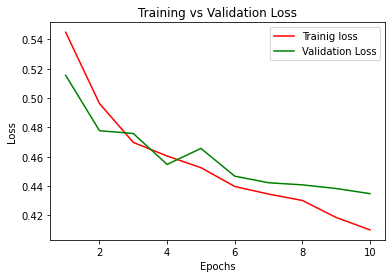

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

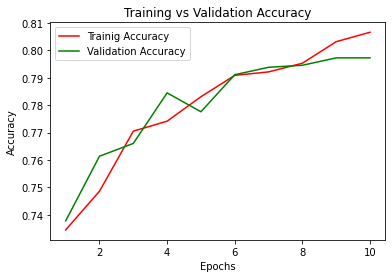

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
def load_img(img_path):
  img_array = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
  try:
    img_array = cv.resize(img_array, (img_width, img_height))
  except:
    pass
  plt.imshow(img_array)
  img_array = np.array(img_array).reshape(-1, img_height, img_width, 1)
  img_array = (np.array(img_array)).astype('float')/255.0
  return img_array

array([[0.36675277]], dtype=float32)

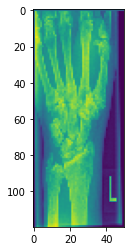

In [50]:
pred = model.predict(load_img('/content/sample17.png'))
pred